^C


  Using cached lmfit-1.3.4-py3-none-any.whl.metadata (8.8 kB)
  Using cached asteval-1.0.8-py3-none-any.whl.metadata (6.8 kB)
  Using cached uncertainties-3.2.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached lmfit-1.3.4-py3-none-any.whl (97 kB)
Using cached asteval-1.0.8-py3-none-any.whl (22 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Using cached uncertainties-3.2.3-py3-none-any.whl (60 kB)

   ---------------------------------------- 0/4 [uncertainties]



ERROR: Could not install packages due to an OSError: [WinError 32] Der Prozess kann nicht auf die Datei zugreifen, da sie von einem anderen Prozess verwendet wird: 'C:\\Users\\User\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\uncertainties\\umath_core.py'
Check the permissions.


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\User\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from uncertainties import ufloat
from uncertainties.umath import sqrt
import scipy.constants as c

1024


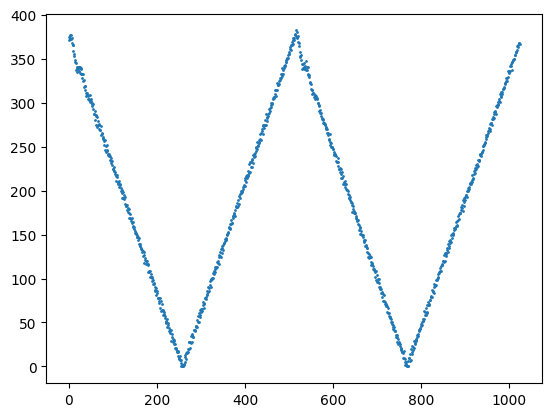

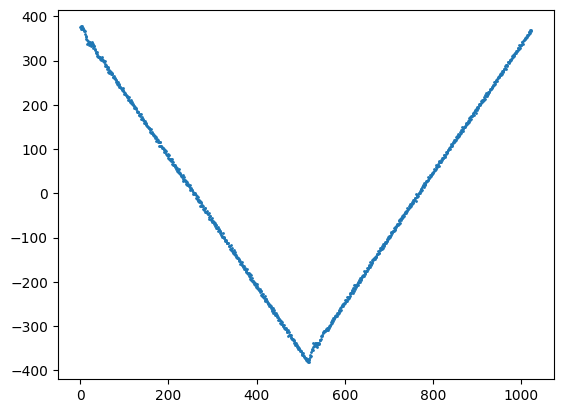

In [4]:
spectrum = np.loadtxt('data/VelocityCalibration_2025-12-15_10-03-29_10_seconds.txt', delimiter = ' ', skiprows = 0)
print(spectrum.shape[0])
plt.scatter(np.arange(spectrum.shape[0]),spectrum,s=1)
#new_spectrum = spectrum[:512] + spectrum[512:]
#plt.scatter(np.arange(spectrum.shape[0]/2),new_spectrum)

plt.show()

new2_spectrum = spectrum
new2_spectrum[int(1024/4):int(1024/4*3)] *= -1

plt.scatter(np.arange(new2_spectrum.shape[0]),new2_spectrum,s=1)





[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 512
    # variables        = 2
    chi-square         = 5388.82864
    reduced chi-square = 10.5663307
    Akaike info crit   = 1209.12445
    Bayesian info crit = 1217.60110
    R-squared          = 0.99977380
[[Variables]]
    slope:     -1.45927359 +/- 9.7196e-04 (0.07%) (init = -1)
    intercept:  374.326823 +/- 0.28689386 (0.08%) (init = 400)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8656
[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 512
    # variables        = 2
    chi-square         = 5153.93486
    reduced chi-square = 10.1057546
    Akaike info crit   = 1186.30586
    Bayesian info crit = 1194.78251
    R-squared          = 0.99978378
[[Variables]]
    slope:      1.45967994 +/- 9.5054e-04 (0.07%) (init = 1)
    interce

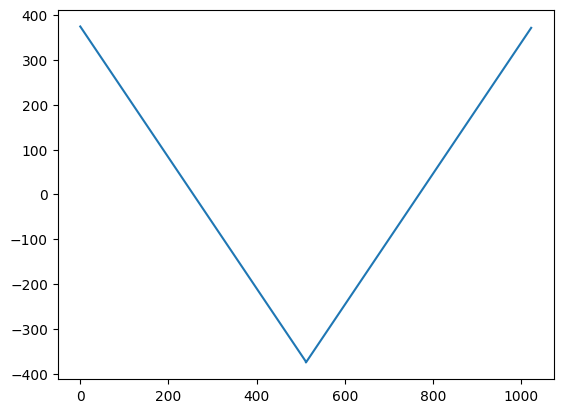

In [32]:
from lmfit.models import LinearModel
from lmfit import Minimizer, report_fit,create_params


model = LinearModel()

spectrum_left = new2_spectrum[:512]
spectrum_right = new2_spectrum[512:]
params_left = create_params(slope = -1, intercept = 400)
params_right = create_params(slope=1,intercept=-800)
#whats the uncertainty on this? idk I think he said about one
y_uncertainty = np.ones(len(spectrum_left))

def func(params, x, y, yerr):
    model = LinearModel(params, x)
    return (model - y) / abs(yerr)

x_data_left = np.arange(spectrum_left.shape[0])
result1 = model.fit(spectrum_left, params_left, x=x_data_left, weights=1/y_uncertainty)
bestfit1 = result1.best_fit
dely1 = result1.eval_uncertainty(sigma=1)



x_data_right = np.arange(spectrum_right.shape[0]) + spectrum_left.shape[0] 
result2 = model.fit(spectrum_right,params_right, x= x_data_right, weights = 1/y_uncertainty)
bestfit2 = result2.best_fit
dely2 = result2.eval_uncertainty(sigma=1)


print(result1.fit_report())
print(result2.fit_report())


results = np.zeros(1024)
results[:512]= bestfit1
results[512:]= bestfit2

result_unc = np.zeros(1024)
result_unc[:512]=dely1
result_unc[512:]=dely2
x_data = np.arange(1024)
plt.plot(x_data,results)

print(results)

data_to_save = np.column_stack((x_data, results, result_unc))
np.savetxt('fit_results.csv', data_to_save, delimiter=',', 
           header='x,y_fit,uncertainty', comments='')

